In [14]:
# Load all the libraries needed for running this notebook
library(tidyverse)
library(repr)
library(ggplot2)
options(repr.matrix.max.rows = 4) #limits output of dataframes to 4 rows

 # Questions  


#### Broad Question: 
Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?  

  
#### Specific Question:

Can a player's age, total play hours, gender, and experience predict whether they subscribes to a game-related newsletter?

---


I'll only use the `players` dataset as it includes all the variables I need: `Age`,`played_hours`, `experience` and `gender` are my predictor/explanatory variables, and `subscribe` is my response variable.  

# Data Description


## Players Dataset 

In [15]:
# Run the code below to load players.csv from Github into an R tibble named `players`.
players_url <- "https://raw.githubusercontent.com/Aylin-Ab/dsci-100-2025w1-group-27/refs/heads/main/players.csv"
players <- read_csv(players_url)
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


This dataframe includes a list of all unique players, including data about each player. It consists of **196 observations** (rows) and **7 variables** (columns):

  - **`experience`**: player's experience level, with 5 levels:
      1. Beginner - completely new to Minecraft
      2. Amateur - has playe a few hours
      3. Regular - regularly plays
      4. Pro - experience and pro player
      5. Veteran - very experienced (playing from before 2015)
  - **`subscribe`**: whether the player subscribed to a game-related newsletter (TRUE = subscribed, FALSE = didn't subscribe)
  - **`hashedEmail`**: an anonymized version of each player's email address used to link player data across the two datasets
  - **`played_hours`**: total number of hours, across different sessions, the player has spent playing on the server
  - **`name`**: player's chosen display name/alias
  - **`gender`** player's gender, with 7 levels/genders (see Table 2.b)
  - **`Age`**: player's age in years

### **Table 1** 
Data types of all variables in players.csv

| Variable | Default Data Type | Suggested Data Type | Categorical or Numerical |
| :-------------: | :---------------: | :--------------------:| :-----------------------: |
| experience    | chr (character)    | fct (factor)        |  Categorical             |
| subscribe     | lgl (logical)      | -                |  *Categorical (Logical)  |
| hashedEmail   | chr (character)    | -                 |  Categorical             |
| played_hours  | dbl (double)       | -                   |  Numerical               |
| name          | chr (character)    | -                |   Categorical            |
| gender        | chr (character)    | fct (factor)        |   Categorical            |
| Age           | dbl (double)       | -                |  Numerical               |

### **Table 2.a** 
Summary stats for numerical variables in players.csv


|Variable    | Mean | Standard Deviation| Min    | Max    | #Missing |
|:----------:|:----:|:----------------: |:------:|:-----: |:--------:|
|played_hours| 5.85 |28.36              | 0      | 223.10 | 0        |
|Age         | 21.14| 7.39              | 9.00   | 58.00  |2         |

### **Table 2.b**
Summary Stats for categorical variables in players.csv

|Variable|#levels (if fct variable)|Level Names| #Missing| Total Count|
|:------:|:-----:|:---------:|:------:|:----:|
|experience|5|Beginner, Amateur, Regular, Pro, Veteran| 0|196|
|subscribe |2|TRUE, FALSE| 0|196|
|hashed_email| n/a|n/a|0|196|
|name| n/a|n/a| 0|196|
|gender| 7 |Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other| 0|196|

In [16]:
# run this code block to view how each summary statistic in Table 2.a & Table 2.b were calculated.
summary(players)

# summary stats for the numerical variable `played_hours`.
players |> summarise(mean_hours  = mean(played_hours, na.rm = TRUE),
    sd_hours     = sd(played_hours, na.rm = TRUE),
    min_hours    = min(played_hours, na.rm = TRUE),
    max_hours    = max(played_hours, na.rm = TRUE),
    n_missing    = sum(is.na(played_hours)))

# summary stats for the numerical variable `Age`.
players |> summarise(mean_Age  = mean(Age, na.rm = TRUE),
    sd_Age     = sd(Age, na.rm = TRUE),
    min_Age    = min(Age, na.rm = TRUE),
    max_Age    = max(Age, na.rm = TRUE),
    n_missing    = sum(is.na(Age)))


# extract the experience column and find all unique experience levels
experience_levels <- players |>
    pull(experience) |>
    unique()
experience_levels

# extract the gender column and find all unique gender levels
gender_levels <- players |>
    pull(gender) |>
    unique()
gender_levels

# number of observations with missing values for each categorical variable
players |>
    summarize(experience_missing = sum(is.na(experience)),
              subscribe_missing = sum(is.na(subscribe)),
              email_missing = sum(is.na(hashedEmail)),
              name_missing = sum(is.na(name)),
              gender_missing = sum(is.na(gender)))

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

mean_hours,sd_hours,min_hours,max_hours,n_missing
<dbl>,<dbl>,<dbl>,<dbl>,<int>
5.845918,28.35734,0,223.1,0


mean_Age,sd_Age,min_Age,max_Age,n_missing
<dbl>,<dbl>,<dbl>,<dbl>,<int>
21.13918,7.389687,9,58,2


[1] "Pro"      "Veteran"  "Amateur"  "Regular"  "Beginner"

[1] "Male"              "Female"            "Non-binary"       
[4] "Prefer not to say" "Agender"           "Two-Spirited"     
[7] "Other"

experience_missing,subscribe_missing,email_missing,name_missing,gender_missing
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


### Issues of Players Dataset


   - Column names don't follow a consistent naming format.
   - `experience` and `gender` are stored as *character* by default, but it's better to treat them as **factors** since they have few distinct levels.
   - Having 2 dp for `played_hours` would improve accuracy and make variations in data more visible. 
   - `gender` includes  "Prefer not to say" and "Other"; should be excluded from analysis if gender is a variable of interest.
   - Two observations have "N/A" values for `Age`; should be excluded.
   - Unclear how `played_hours` was tracked/calculated (see code block below).

In [17]:
# run this code block to see why calculation of played_hours is unclear/inconsistent. 

sessions_url <- "https://raw.githubusercontent.com/Aylin-Ab/dsci-100-2025w1-group-27/refs/heads/main/sessions.csv"
sessions <- read_csv(sessions_url) # to load the sessions.csv

# choose a random email identifier (i.e., player) with small hours_played to simplify calculations
player1 <- sessions |>
    filter(hashedEmail == "8eae13e0f5823d9c48fe7b89695ea231f96f644f664bcc74c5a07f7d0a1135bd") |>
    left_join(players)
player1 

# As you can see in the tibble below, this player has only 1 play session, from 14:01 to 14:35 on 02/05/2024.

# calculate the duration of the play session in hours
start_time_mins <- (14 * 60 + 1)
end_time_mins <- (14 * 60 + 35)

duration_hours <- (end_time_mins - start_time_mins) / 60 
duration_hours 

# output played_hours from player1
played_hours <- player1 |>
    select(played_hours) |>
    pull()

played_hours

# duration_hours and played_hours should be identical if researchers calculated played_hours by combining total session durations for each player.
# However, if we round 0.56 to 1 dp, we get 0.6, not 0.5. 
# You can try the same procedure with other players and see the inconsistency/unclarity of calculated playe_hours.
duration_hours == played_hours

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(hashedEmail)`


hashedEmail,start_time,end_time,original_start_time,original_end_time,experience,subscribe,played_hours,name,gender,Age
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
8eae13e0f5823d9c48fe7b89695ea231f96f644f664bcc74c5a07f7d0a1135bd,02/05/2024 14:01,02/05/2024 14:35,1.71466e+12,1.71466e+12,Pro,TRUE,0.5,Gray,Male,12


[1] 0.5666667

[1] 0.5

[1] FALSE

## Sessions Dataset


In [18]:
# Run the code below to load sessions.csv from GitHub into an R tibble named `sessions`.
sessions_url <- "https://raw.githubusercontent.com/Aylin-Ab/dsci-100-2025w1-group-27/refs/heads/main/sessions.csv"
sessions <- read_csv(sessions_url)
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


This dataframe includes a list of all individual play sessions by each player, including data about each session. It consists of **1535 observations** (rows) and **5 variables** (columns):

- **`hashedEmail`**: an anonymized version of each player's email address used to link player data across the two datasets
- **`start_time`**: start timestamp of each play session, including the date and time (h:m)
- **`end_time`**: end timestamp of each play session, including the date and time (h:m)
- **`original_start_time`**: represent the same values as in `start_time`, but recorded in UNIX time (milliseconds)
- **`original_end_time`**: represent the same values as in `end_time`, but recorded in UNIX time (milliseconds)

### **Table 3**
Data types of all variabels in sessions.csv

| Variable Name  | Data Type      | Categorical vs Numerical | 
| -------------       | ---------------    | ---------------     | 
| hashedEmail         | chr (character)    |  Categorical             |
| start_time          | chr (character)    |  Categorical             |
| end_time            | chr (character)    |  Categorical             |
| original_start_time   | dbl (double)       |   Numerical              |
| original_end_time      | dbl (double)       |  Numerical               |

### **Table 4.a**
Summary stats for numerical variables in sessions.csv (in miliseconds)

|Variable    | Mean | Standard Deviation| Min    | Max    | #Missing |
|:----------:|:----:|:----------: |:------:|:-----: |:--------:|
|original_start_time|$1.72 \times 10^{12}$ | 3557491589 | $1.71 \times 10^{12}$  | $1.73 \times 10^{12}$ | 0        |
|original_end_time  | $1.72 \times 10^{12}$| 3552813134 | $1.71 \times 10^{12}$ | $1.73 \times 10^{12}$  |2         |

### **Table 4.b**
Summary stats for categorical variables in sessions.csv  

|Variable|#Missing|Total Count|
|:------:|:------:|:---------:|
|hashedEmail|0|1535|
|start_time|0|1535|
|end_time|2|1535|

In [19]:
# run this code block to view how each summary statistic in Table 4.a & Table 4.b were calculated.
summary(sessions)

# summary stats for the numerical variable `original_start_time`.
sessions |> summarise(mean_org_start  = mean(original_start_time, na.rm = TRUE),
        sd_org_start     = sd(original_start_time, na.rm = TRUE),
        min_org_start    = min(original_start_time, na.rm = TRUE),
        max_org_start    = max(original_start_time, na.rm = TRUE),
        n_missing        = sum(is.na(original_start_time))) 

# summary stats for the numerical variable `original_end_time`.
sessions |> summarise(mean_org_end  = mean(original_end_time, na.rm = TRUE),
    sd_org_end      = sd(original_end_time, na.rm = TRUE),
    min_org_end     = min(original_end_time, na.rm = TRUE),
    max_org_end     = max(original_end_time, na.rm = TRUE),
    n_missing       = sum(is.na(original_end_time)))

# number of observations with missing values for each categorical variable
sessions |>
    summarize(email_missing = sum(is.na(hashedEmail)),
              start_missing = sum(is.na(start_time)),
              end_missing = sum(is.na(end_time)))

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

mean_org_start,sd_org_start,min_org_start,max_org_start,n_missing
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1.719201e+12,3557491589,1.7124e+12,1.72733e+12,0


mean_org_end,sd_org_end,min_org_end,max_org_end,n_missing
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1.719196e+12,3552813134,1.7124e+12,1.72734e+12,2


email_missing,start_missing,end_missing
<int>,<int>,<int>
0,0,2


### Issues of Sessions Dataset
   - Some observations have identical values of `original_start_time` and `original_end_time` (data-collection error or interrupted sessions?)
   - `start_time` and `end_time` combine date and time info in a single column. For a tidier data, each should be separated into two columns (e.g., `start_date` & `start_timestamp`).
- Two observations have missing values for `end_time` and `original_end_time`.

# Exploratory Data Analysis and Visualization

In [23]:
# convert experience and gender columns into factor variables, correct order of experience levels and remove unuseful gender info
players <- players |>
    mutate(experience = factor(experience,
      levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"),
      ordered = TRUE)) |>
    mutate(gender = as.factor(gender)) |>
    filter(!gender %in% c("Prefer not to say", "Other")) # exclude since they don't provide meaningful info about player's gender
    

#  convert subscribe column into a factor (TRUE = Subscribed, FALSE = Not Subscribe)
players <- players |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(subscribe = factor(subscribe, levels = c(TRUE, FALSE), labels = c("Subscribed", "Not Subscribed")))

players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<ord>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,NA,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,NA,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,NA,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,NA,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


### 1. How many players subscribed to the game-related newsletter and how many didn't?

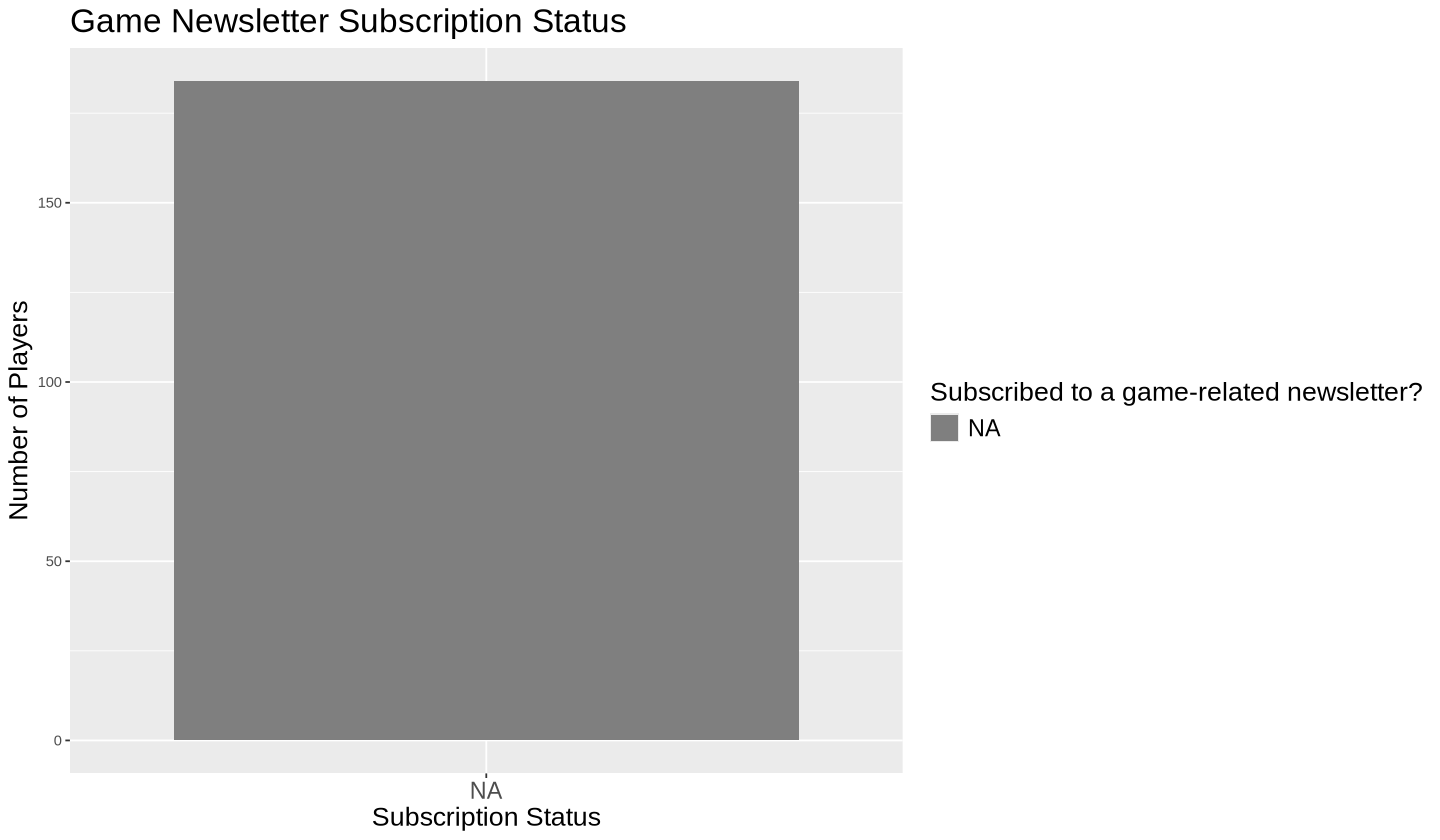

In [24]:
# graph a bar plot to show the distribution of players' subscription status
options(repr.plot.width = 12, repr.plot.height = 7)

subscribe_plot <- players |>
    ggplot(aes(x = subscribe, fill = subscribe)) +
    geom_bar() +
    labs(x = "Subscription Status", y = "Number of Players", fill = "Subscribed to a game-related newsletter?") +
    ggtitle("Game Newsletter Subscription Status") +
    theme(plot.title = element_text(size = 20),
          axis.title.x = element_text(size = 16), 
          axis.title.y = element_text(size = 16),
          axis.text.x = element_text(size = 14),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14))

subscribe_plot

Most players in the dataset (~ 140) subscribed to the game-related newsletter, which is more than twice the number of non-subscribers (~ 50). This imbalance means the subscription variable (our outcome variable) is not evenly distributed, which may make it harder for the model to accurately learn patterns for the smaller non-subscriber group. 

### 2. What is the relationship between age, playtime, and player characteristics (experience, gender)?

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


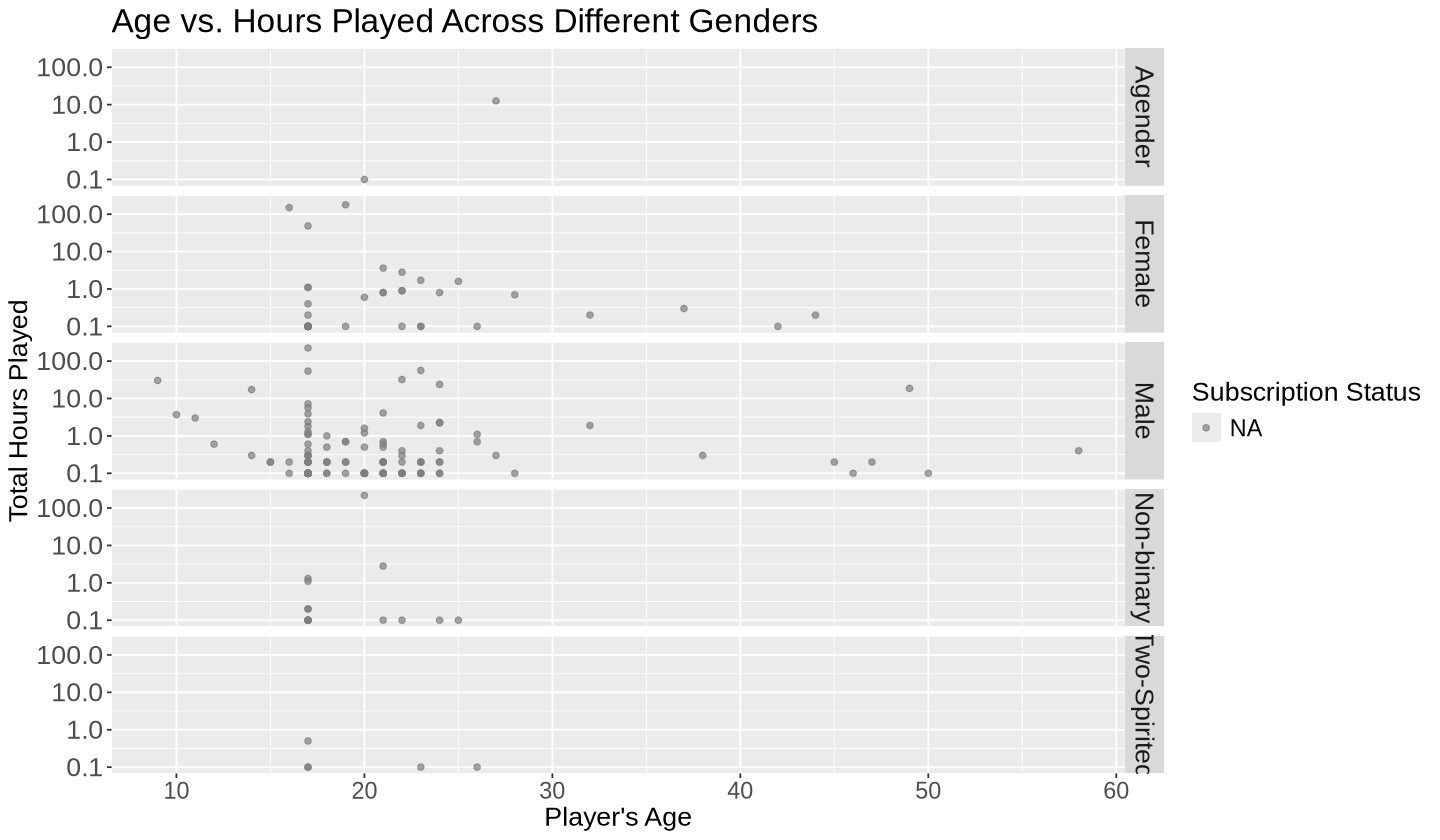

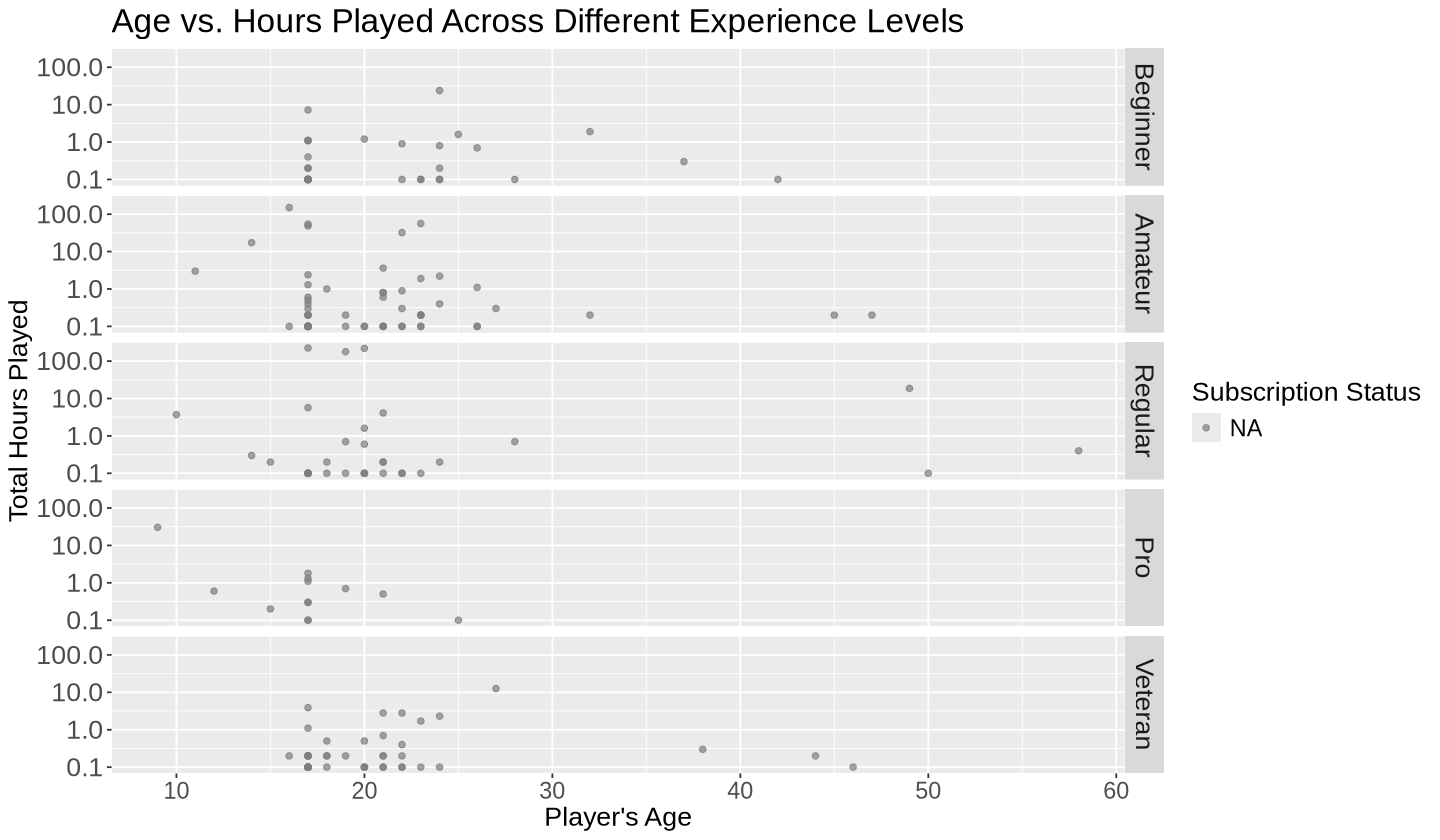

In [25]:
options(repr.plot.width = 12, repr.plot.height = 7)

# Create a scatter plot to show the relationship between age, played hours, gender and subscription
with_gender_plot <- players |>
    ggplot(aes(x = Age, y = played_hours + 0.1, color = subscribe)) + # Added 0.1 to played_hours so that values at 0 can appear on a log scale (without this shift, they'd be cut/remove from the plot)                                         
    geom_point(alpha = 0.7) +
    scale_y_log10() + # use log10 scaling to handle the strong right-skew and make the plot more readable
    facet_grid(vars(gender)) +
    labs(x = "Player's Age", y = "Total Hours Played", color = "Subscription Status") +
    ggtitle("Age vs. Hours Played Across Different Genders") +
    theme(plot.title = element_text(size = 20),
          axis.title.x = element_text(size = 16), 
          axis.title.y = element_text(size = 16),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_text(size = 14),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          strip.text = element_text(size = 16))

with_gender_plot


# Create a scatter plot to show the relationship between age, played hours, experience and subscription
with_experience_plot <- players |>
    ggplot(aes(x = Age, y = played_hours + 0.1, color = subscribe)) + # Added 0.1 to played_hours so that values at 0 can appear on a log scale (without this shift, they'd be cut/remove from the plot)                                         
    geom_point(alpha = 0.7) +
    scale_y_log10() + # use log10 scaling to handle the strong right-skew and make the plot more readable
    facet_grid(vars(experience)) +
    labs(x = "Player's Age", y = "Total Hours Played", color = "Subscription Status") +
    ggtitle("Age vs. Hours Played Across Different Experience Levels") +
    theme(plot.title = element_text(size = 20),
          axis.title.x = element_text(size = 16), 
          axis.title.y = element_text(size = 16),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_text(size = 14),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          strip.text = element_text(size = 16))

with_experience_plot

Across both plots, no correlation is visible between players’ age and total hours played. Across both gender and experience levels, the scatterplots do not show a clear separation between subscribers and non-subscribers as there's noticeable overlap. Overall, while minor differences might exist, the visualizations don't reveal strong or consistent patterns that distinguish subscribers from non-subscribers. This suggests that the K-NN model will probably have only modest predictive performance.

# Methods and Plan

I'll use **K-NN classification model**, with `subscription` as the response variable and `Age`,`played_hours`, `gender`, and `experience`as predictors. 

K-NN is appropriate because the outcome variable is categorical and the main predictors are numerical, and it is also the only classification method covered in this course. However, the exploratory visualizations showed weak or no relationship between age, playtime, experience, gender, and subscription, so the model will likely have limited predictive power and relatively low accuracy.

### Assumptions:
- K-NN calculates distances between neigherest neighbors, assuming that players with similar characteristic (age, play-time etc)  tend to have similar subscription behavior.
- Numeric predictors should be on comparable scales so that no single variable dominates the distance calculation.
- There must be enough subscribers and non-subscribers for the model to learn patterns from both groups.

### Limitations:
- Since the scatterplots do not show clear or consistent patterns separating subscribers from non-subscribers, the model’s predictive performance will likely be modest or weak.
- There's many more subscribers than non-subscribers, so model may lean toward predicting "subscribe" most of the time.
- Small sample size (~ 194 players) means that the data splits used for training and validation will also be small.

### Model Comparison and Selection:
- Tune k from 1 to 30. This range is appropriate because the minority class (non-subscribers) has ~ 50 observations, so very large k values would ignore the smaller class.
- Perform 5-fold cross-validation on the *training data* to estimate performance for each k.
- Compare model performance using accuracy and select the k with the highest cross-validated accuracy (recall would be a better metric since data's imbalanced, but we only covered code for accuracy)

### Data Processing Plan:
#### Train-test split
- Perform initial stratified split (%75 training, %25 testing) to keep class proportions consistent across sets and have enough data for training and testing.
- Put testing set aside and train model only on training set.
  
#### Cross-validation
- Apply 5-fold stratified cross-validation on the training set (strata = 0.75) to get training and validation sets for tuning.

#### Preprocessing (recipe)
- Remove/filter missing data.
- Scale and center `Age` and `played_hours`.
- Convert `subscribe` into a factor variable
- Convert `experience` and `gender` into dummy variables.
